# SV model with particle filter (WIP) - free params and proposal, dual optimization

In [1]:
import matplotlib.pyplot as plt
import torch
import ptvi

In [2]:
data_seed, algo_seed = 123, 123
params = dict(a=1., b=0., c=.95)
T = 200

In [3]:
model = ptvi.FilteredSVModelDualOpt(
    input_length=T, num_particles=30, resample=True)
model

Stochastic volatility model for dual optimization of model and proposal:
	x_t = exp(a * z_t/2) ε_t      t=1, …, 200
	z_t = b + c * z_{t-1} + ν_t,  t=2, …, 200
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Particle filter with 30 particles, AR(1) proposal:
	z_t = d + e * z_{t-1} + η_t,  t=2, …, 200
	z_1 = d + 1/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [4]:
torch.manual_seed(data_seed)
y, z_true = model.simulate(**params)

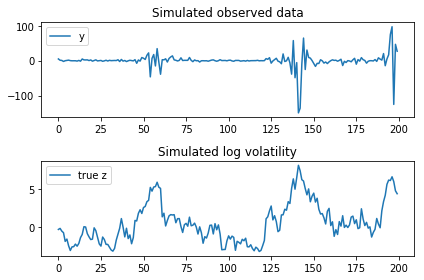

In [5]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [6]:
torch.manual_seed(algo_seed)
fit = ptvi.dual_sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Alternating model/proposal structured SGVB Inference: Particle filtered stochastic volatility model
  - Estimating elbo with M=1;
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed model elbo = -890.81, proposal elbo = -746.00
       1. smoothed model elbo = -920.46, proposal elbo = -992.40
       2. smoothed model elbo = -900.14, proposal elbo =-1093.22
       4. smoothed model elbo =-1186.64, proposal elbo =-1371.54
       8. smoothed model elbo =-1538.66, proposal elbo =-1350.23
      16. smoothed model elbo =-8639.82, proposal elbo =-1136.85
      32. smoothed model elbo =-5822.99, proposal elbo =-1263.36
      64. smoothed model elbo 

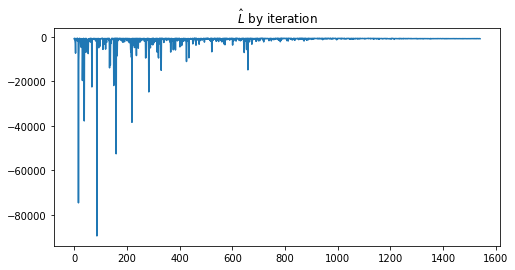

In [7]:
plt.rcParams['figure.figsize'] = [8, 4]
fit.plot_elbos()

In [8]:
fit.summary(true=params)

,mean,sd,true
a,2.894019,0.110232,1.00
b,-0.612179,0.093701,0.00
c,0.402253,0.118776,0.95
d,0.106154,2.757296,NaN
e,0.427348,0.343405,NaN


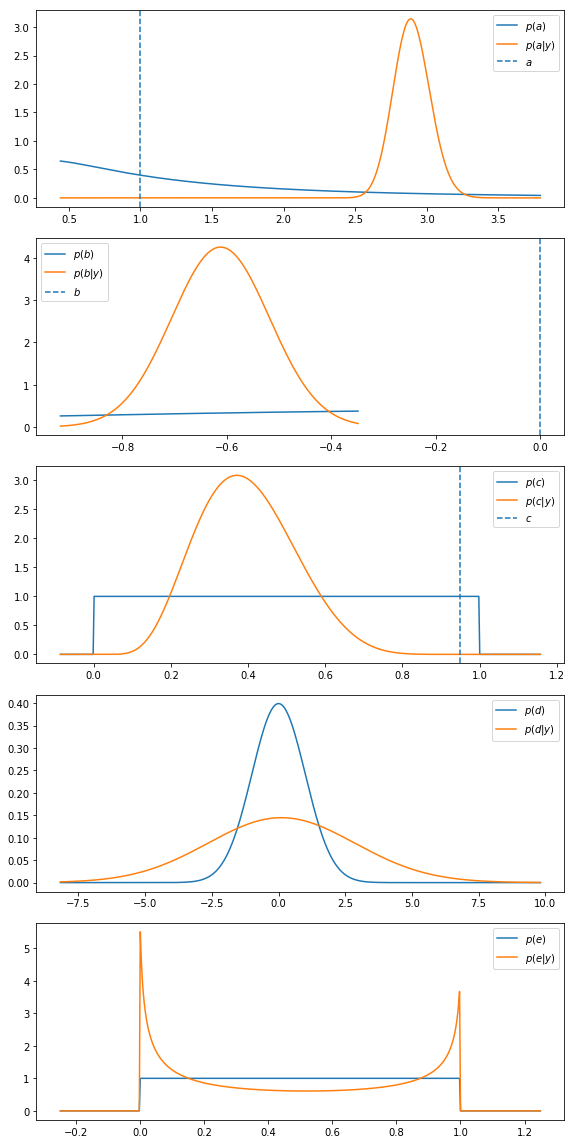

In [9]:
plt.rcParams['figure.figsize'] = [8, 16]
fit.plot_global_marginals(**params, cols=1)

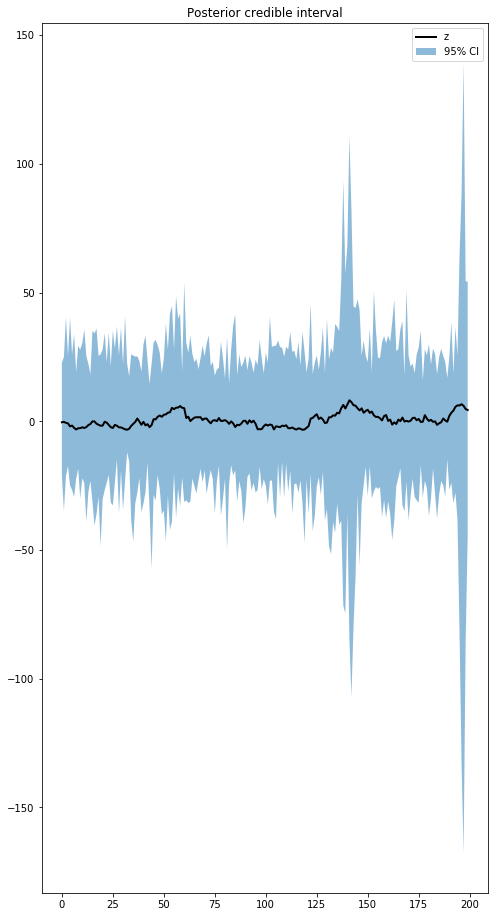

In [10]:
fit.plot_latent(N=50, true_z=z_true)

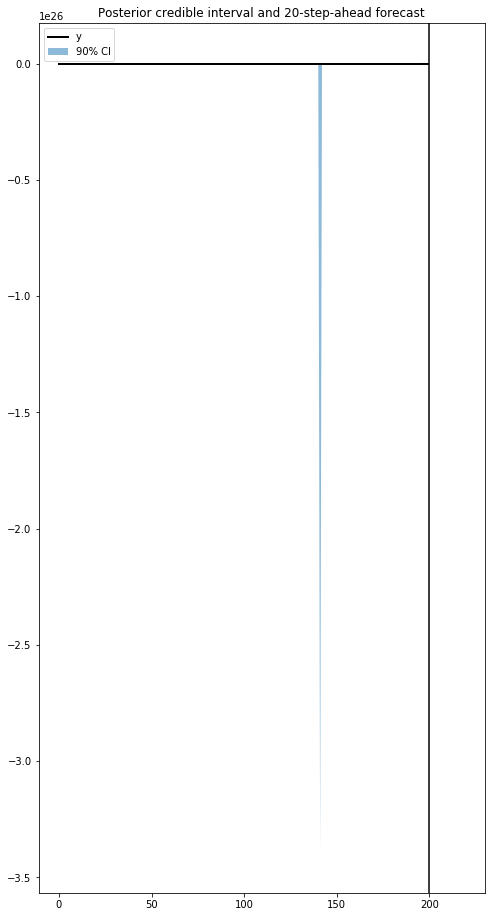

In [11]:
fit.plot_pred_ci(N=50, α=.1, true_y=y, fc_steps=20)